# Path Refinement

This notebook shows raidnr capability of generating and smoothing a new infrastructural alignment. It is made of 3 main parts:

1. Context
2. New alignment design
3. New alignment refinement


In [1]:
import os
import math
import sys
import imp
import requests
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
os.getcwd()
# raidnr imports
mainPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, mainPath)
from raidnr.bwgrid.grid import Grid
from raidnr.core.alignment import Alignment
from raidnr.manager.design_manager import DesignManager
import raidnr.bwgrid.grid_transformations as gt
from raidnr.config import GRANULARITY, METRICS, URL, crv_thresholds
from raidnr.manager.remapper import Remapper

### Defining Context Area: Bounding Box

Context data has been already pre-processed, meaning that vector open data has been trimmed, buffered and rasterised to fit a specific bounding box. Look at the relative example for further information.

NOTE: The extension of the bounding box is set here to match the raster dimensions - **do not change it**

In [2]:
# bounding box
# a = [407712.2503762188,413445.1119170117] # DO NOT CHANGE
# b = [414570.2503762188,417282.1119170117] # DO NOT CHANGE
# in WGS84
a = [-1.8855285644531252,53.62224480831412]
b = [-1.7820167541503908,53.654100389869235]
# a_= gt.bng_to_wgs(a)
# b_= gt.bng_to_wgs(b)
a = gt.wgs_to_bng(a)
b = gt.wgs_to_bng(b)
# bounding box
bbox = [a[0],a[1],b[0],b[1]]
# pre-processed raster matching above coordinates
data_folder = 'data/path_smoothening'
rail_clip_fn = os.path.join(data_folder,'clipped_rail.shp')

### Importing Context Data from Surrounding

Context data is imported into a raidnr.bwgrid.grid.Grid object. Here, we load all the tiff files from the `data_folder` by the `gt.get_grid_from_directory(<data_folder>)` extension method. The folder includes a stack of `.tif` images, each of this carries data of one topographical layer (e.g. building footprints).

In [3]:
print("Reading files...\n")
grid_array = gt.get_grid_from_directory(data_folder)

print("Initializing Grid...\n")
grid = Grid(grid_array, bbox, GRANULARITY)

print(grid)

Reading files...

Initializing Grid...

Grid object at 1449957555896:
  Bounds: [407669.0352878211, 413973.4242114245, 414504.815884908, 417533.5412186192]
  Granularity: 3.0 m


### Importing Existing Alignment

The existing alignment, clipped on the context area (bounding box) is loaded. This will be useful to compare the new and existing, or to re-use part of the existing whil redefining a new route.

In [4]:
# Process existing alignment data (include speed data)
print('Init Alignment...\n')

ex_alignment = Alignment.from_shp_poly(fn=rail_clip_fn, id=2100, resample_dist=300, granularity=3.)

print(ex_alignment)

Init Alignment...

Alignment object at 1449958791600
  ID: 2100
  length: 9148.76
  no of points: 3050
  granularity: 3.0m


### Design Manager

Each design session must be handled through a DesignManager object.

In [5]:
manager = DesignManager(grid=grid, session_name="b6bed389f6f67e8c", existing_alm=ex_alignment)
print(manager)

### Design New Alignment

The design of a new alignment requires two 

In [6]:
# Design parameters
# start = (-1.8068218231201174, 53.63705606607417)
# end  =  (-1.8615803527832033, 53.62067017257395)

start = (-1.8164421992383042, 53.63100464559422)
end  =  (-1.8601741739514162, 53.64543965328287)

start = (-1.7934421992383042, 53.63700464559422)
end  =  (-1.8601741739514162, 53.62543965328287)

start_ = gt.wgs_to_bng(start)
end_ = gt.wgs_to_bng(end)

weights = {
    "Building":5, 
    "CarChargingPoint":0,
    "DTM":0,
    "ElectricityTransmissionLine":0,
    "Foreshore":0,
    "FunctionalSite":0,
    "Glasshouse":0,
    "Greenspaces":0,
    "ImportantBuilding":0,
    "MotorwayJunction":0,
    "NationalParks":0,
    "RailwayStation":0,
    "RailwayTrack":0,
    "RailwayTunnel":0,
    "Road":0,
    "RoadTunnel":0,
    "Roundabout":1,
    "Slope":0,
    "SurfaceWater_Area":0,
    "SurfaceWater_Line":0,
    "TidalBoundary":5,
    "TidalWater":0,
    "Woodland":0
}

Run the cell below to execute the new alignment design.

In [7]:
manager.design_new_alm(start_, end_, weights, naa='alignment')
print('\nProduced one new alignment.\n  ID:',manager.alignment_ID,'\n  version:',manager.alignment_version)

Alignment object at 1449958791600
  ID: 2100
  length: 9148.76
  no of points: 3050
  granularity: 3.0m
ERROR: Coordinates out of the Grid. (414707.9003654574, 417777.1119170117) not within [407669.0352878211, 413973.4242114245, 414504.815884908, 417533.5412186192] as [minx,maxx,miny,maxy]
ERROR: Coordinates out of the Grid. (414706.5606569257, 417774.4275614054) not within [407669.0352878211, 413973.4242114245, 414504.815884908, 417533.5412186192] as [minx,maxx,miny,maxy]
ERROR: Coordinates out of the Grid. (414705.23998233036, 417771.7341689522) not within [407669.0352878211, 413973.4242114245, 414504.815884908, 417533.5412186192] as [minx,maxx,miny,maxy]
ERROR: Coordinates out of the Grid. (414703.9368103947, 417769.0324658918) not within [407669.0352878211, 413973.4242114245, 414504.815884908, 417533.5412186192] as [minx,maxx,miny,maxy]
ERROR: Coordinates out of the Grid. (414702.6496098427, 417766.3231784649) not within [407669.0352878211, 413973.4242114245, 414504.815884908, 4175


Produced one new alignment.
  ID: 14553ff4-d4a2-4e40-98e2-68385e9f17fc 
  version: 1


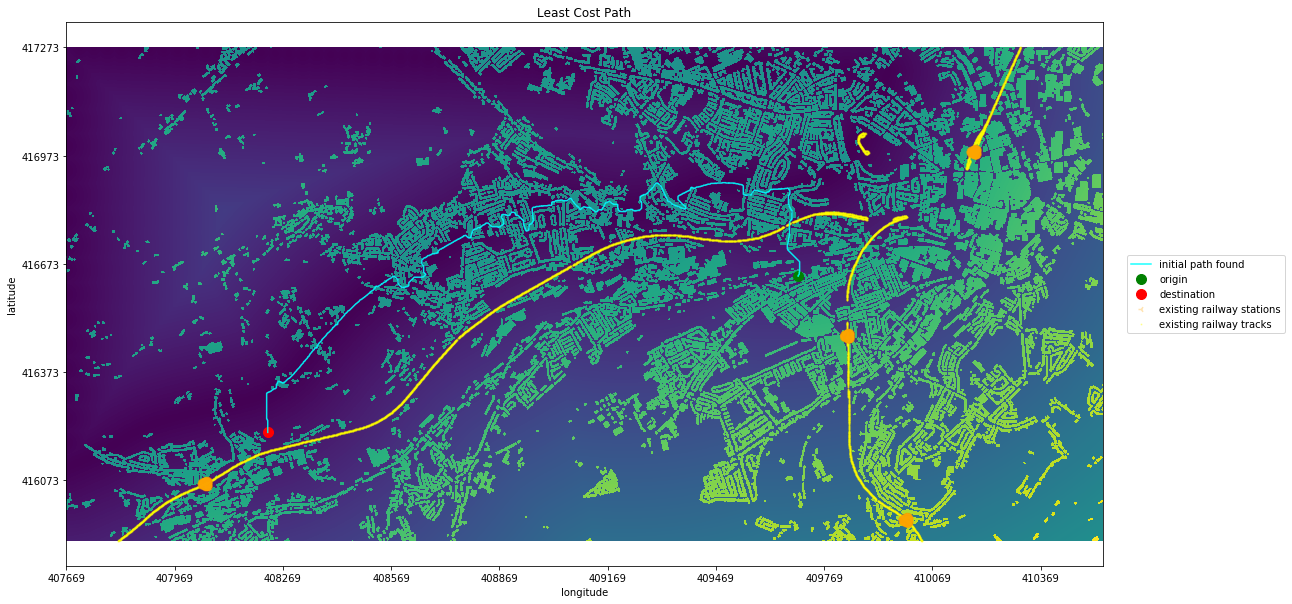

In [8]:
manager.plotGridLayer(show=True);

### Refine New Alignment

The newly designed alignment requires to be smoothened. Here, we smooth the grid-based alignment against curvature, to address maximum cuvature constraints.

In [9]:
crv_thresholds

{0: [1.0, 0.0033333333333333335],
 1: [0.0033333333333333335, 0.002],
 2: [0.002, 0.001],
 3: [0.001, 0.0002],
 4: [0.0002, 0.000125],
 5: [0.000125, 0.0]}

In [10]:
r = Remapper(crv_thresholds)
print(r)

Remapper object at 1450683984304. Thresholds:
{
 "0": [
  1.0,
  0.0033333333333333335
 ],
 "1": [
  0.0033333333333333335,
  0.002
 ],
 "2": [
  0.002,
  0.001
 ],
 "3": [
  0.001,
  0.0002
 ],
 "4": [
  0.0002,
  0.000125
 ],
 "5": [
  0.000125,
  0.0
 ]
}
To values:
min: 0.0
max: 1.0


In [11]:
refine_params = {'metrics':{'mweights':{'curvature':1.0}, 'mfuncs':{'curvature':r},'min_value':0.1, 'max_value':10.0}}

In [12]:
manager.refine_new_alm(refine=refine_params, iterations=5, s=553)

Running curvature...


C:\Users\ccampanile\source\repos\RAID_NR\raidnr\util\ext_methods.py:265: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./curvature
C:\Users\ccampanile\source\repos\RAID_NR\raidnr\util\ext_methods.py:259: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt((a+(b+c))*(c-(a-b))*(c+(a-b))*(a+(b-c))) / 4.
C:\Users\ccampanile\source\repos\RAID_NR\raidnr\util\ext_methods.py:291: RuntimeWarning: invalid value encountered in double_scalars
  r = np.sum(a[max(0,n-ii):ii+n]) / ((ii+n) - max(0,n-ii))


Running curvature...
Running curvature...
Running curvature...
Running curvature...


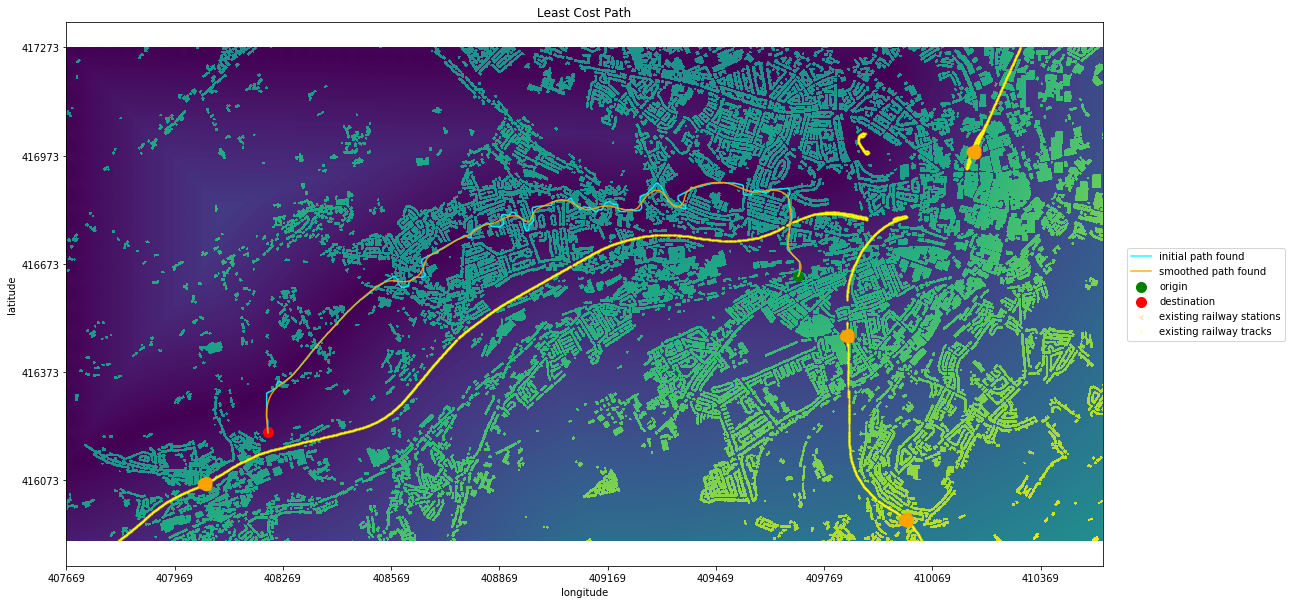

In [13]:
manager.plotGridLayer(show=True);

### Analyse New and Refined Alignments

In [14]:
# analyse
manager.analyse_new_alm()


Running curvature...
Running permissible_speed...
Running actual_speed...
Running elevation_difference...
Running ground_elevation...
Running alignment_elevation...
Running gradient_ratio...


C:\Users\ccampanile\source\repos\RAID_NR\raidnr\util\ext_methods.py:787: RuntimeWarning: divide by zero encountered in true_divide
  diff_ = abs(np.diff(np.array(X)))/np.diff(np.array(Y))


Running gradient_pct...
Running gradient_smooth...
Running gradient_labels...
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERRO

C:\Users\ccampanile\source\repos\RAID_NR\raidnr\util\ext_methods.py:468: RuntimeWarning: invalid value encountered in double_scalars
  elevation = (e1*d1+e2*d2+e3*d3+e4*d4)/dt



ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object does not support indexing
ERROR: 'FrenetFrame' object